# Machine Learning Pipeline for Automated Detection of Magnetospheric Boundaries

The work package "Machine Learning Solutions for Data Analysis and Exploitation in Planetary Science" within Europlanet 2024 Research Infrastructure will develop machine learning (ML) powered data analysis and exploitation tools optimized for planetary science. <br>
In this workshop, we will introduce a ML pipeline for the automated detection of magnetospheric boundaries in spacecraft in situ data around Earth.. First, we will briefly give an overview about the physical problem. Then, we will guide the participants through the developed ML code with the help of a sample data set and discuss problems encountered during the development of the pipeline. <br>

Europlanet 2024 RI has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No 871149. <br><br>

### The problem

Planetary magnetospheres create multiple sharp boundaries, such as the bow shock, where the solar wind plasma is decelerated and compressed, or the magnetopause, a transition between solar wind field and planetary field. 

![img1](img1.png)

There have been several quite successful attempts to automatically segment in situ time series, which are available on many planetary missions. Labelling the different regions such as the magnetosphere, the magnetosheath and the background solar wind, the segmented maps were subsequently used to detect boundary crossings and build an according database (see [Nguyen et al.(2019)](https://doi.org/10.5194/angeo-2019-149) or [Olshevsky et al.(2019)](https://doi.org/10.1029/2021JA029620)). From an exploratory point of view, we were interested in whether it would be possible to train a model on a catalog of bow shock crossings in order to obtain these directly.

In [1]:
# at first, we want to import the necessary packages

%load_ext autoreload
%autoreload 2

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')
import sys

import pickle 
import numpy as np
import pandas as pds
import datetime
import preprocess as pp
import crossing as cr
import matplotlib.pyplot as plt

In [2]:
# then we load the list of boundary crossings and the dataset

years = [2006,2007,2008]

sc = 'C1'
width = 10
crosslist = cr.get_crosslist('CL_BS_crossings_2002_2014.txt',sc,years)

data = pds.read_csv('data_resampled.csv',index_col=0)
data.index = pds.to_datetime(data.index)

data.head()

,dens,tpar,tperp,vel_gse_x,vel_gse_y,vel_gse_z,v_abs,b_gse_x,b_gse_y,b_gse_z,b_abs
2002-01-01 10:02:00,0.059457,2.482093,1.885715,-43.188165,-24.346047,14.438007,52.958595,282.360273,291.595899,-224.734868,463.964171
2002-01-01 10:03:00,0.029754,3.175076,2.899928,-7.019096,3.785095,-0.676816,20.435830,281.350783,287.623246,-227.620340,462.275956
2002-01-01 10:04:00,0.033762,3.154136,2.893417,-8.797901,6.791396,-1.028877,28.503831,280.246967,282.793030,-231.138230,460.367226
2002-01-01 10:05:00,0.030752,3.716784,3.317599,3.275991,0.589341,-2.872409,20.862708,279.683697,278.400257,-233.341937,458.453549
2002-01-01 10:06:00,0.037798,2.558630,2.727796,-21.234758,1.442683,-1.286524,32.414298,279.117587,274.066436,-235.287040,456.487799


There appear quite large differences in magnitude of the various features. Therefore we scale our data!

In [3]:
# scale the data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale.fit(data)

data_scaled = pds.DataFrame(index = data.index, columns = data.columns, data = scale.transform(data))

data_scaled.head()

,dens,tpar,tperp,vel_gse_x,vel_gse_y,vel_gse_z,v_abs,b_gse_x,b_gse_y,b_gse_z,b_abs
2002-01-01 10:02:00,-0.027453,-0.001001,-0.001,-0.000979,-0.001048,0.000947,-0.001037,2.626536,2.409025,-1.839272,2.098737
2002-01-01 10:03:00,-0.027529,-0.001001,-0.001,-0.000976,-0.001043,0.000935,-0.001040,2.617199,2.377015,-1.865195,2.089613
2002-01-01 10:04:00,-0.027518,-0.001001,-0.001,-0.000976,-0.001042,0.000934,-0.001039,2.606989,2.338094,-1.896799,2.079298
2002-01-01 10:05:00,-0.027526,-0.001001,-0.001,-0.000975,-0.001044,0.000933,-0.001040,2.601780,2.302699,-1.916597,2.068956
2002-01-01 10:06:00,-0.027508,-0.001001,-0.001,-0.000977,-0.001044,0.000934,-0.001039,2.596544,2.267779,-1.934071,2.058333


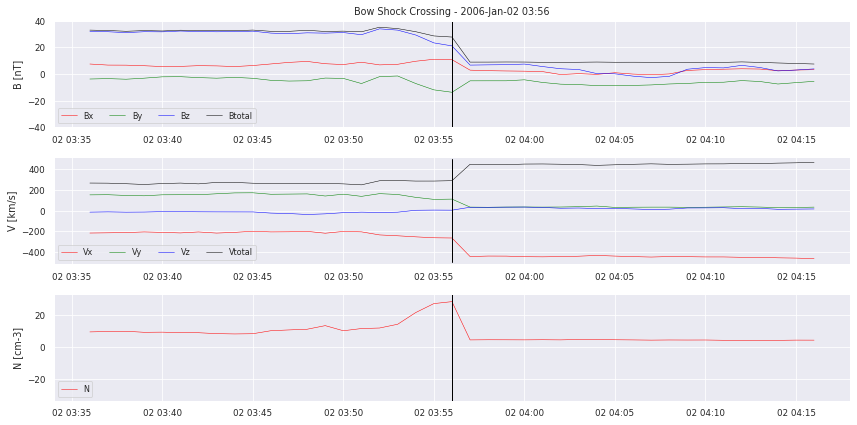

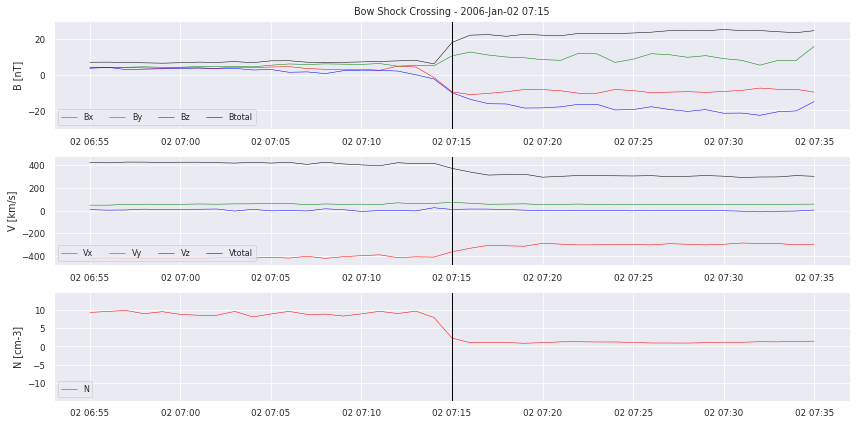

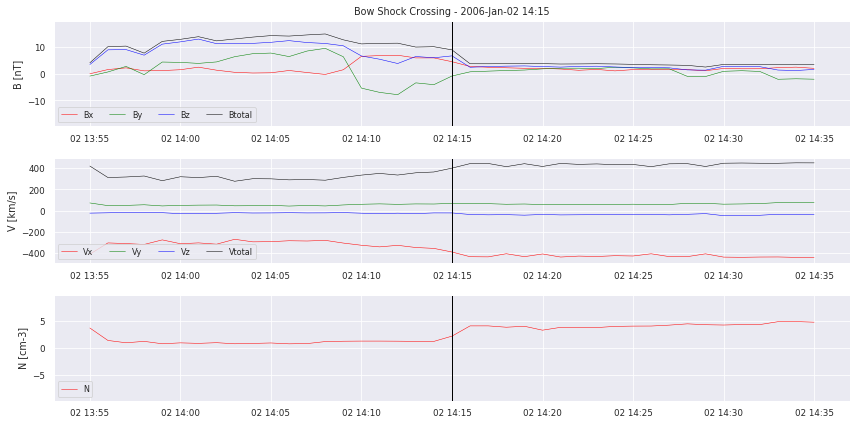

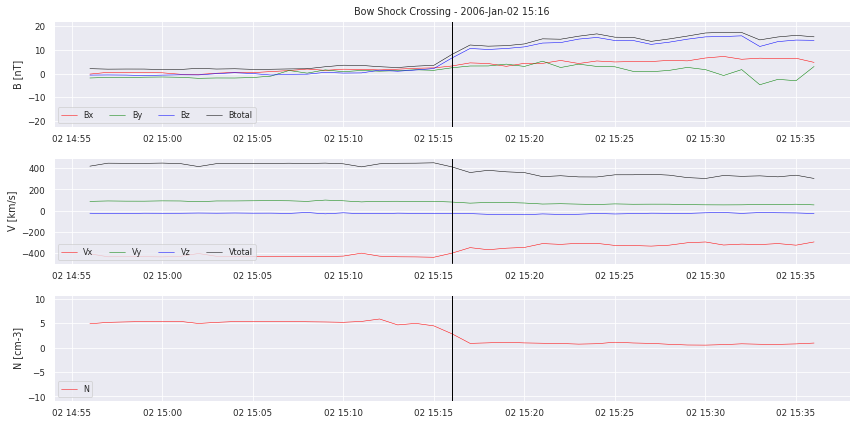

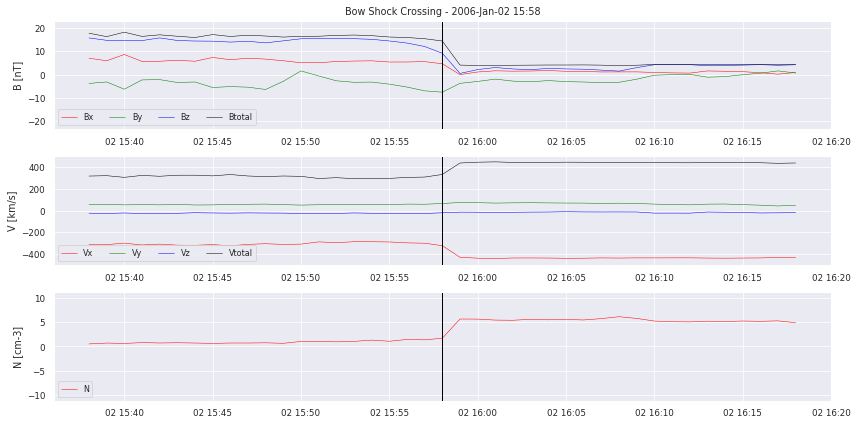

In [4]:
# we plot examples

for i in range(0,5):
    crosslist[i].plot_cross(data, delta=20,label=None,pred=None)

Let's take a closer look at the data. We can clearly see the boundary crossing in the example plotted. But how will we translate this for our model to learn? Simply segmenting the time series into "crossing" and "no crossing" will give a HUGE data imbalance. So it does not seem to work as a classification problem. We also have to decide on how to deliver the data to a possible model. Single points? Or time frames of multiple hours?

In [5]:
# load label
similarities = pds.read_csv('similarities_C1_width'+str(width)+'.csv', index_col = 0)
similarities.index = pds.to_datetime(similarities.index)

We decided on a parameter between 0 and 1, that simultanously defines if a given time frame contains a bow shock crossing and how far from the center it occurs. The size of the window was chosen to be 20 minutes in order to not contain more than two crossings in one image but still include enough data to perfectly see the crossing.

![label](label.png)

Nevertheless, the problem of imbalanced data is not yet completely resolved. Let's see why:

In [6]:
cr.crossingsperyear(crosslist,years)

2006: 46
2007: 141
2008: 138


Given the fact that each crossing now equals 20 non-zero values, we still have a highly imbalanced dataset. So let's take a look at when our crossings actually happen.

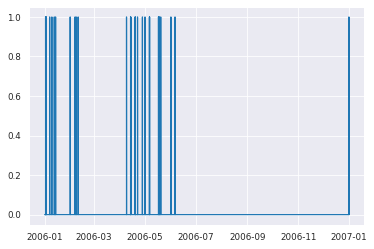

In [7]:
plt.plot(similarities.index[similarities.index.year==2006],similarities[similarities.index.year==2006])

There are times where the spacecraft does not cross the bow shock for quite a while, for example when it is in the night side part of the magnetopause or too far away in the solar wind. So to simplify the problem, we will only use the times in which we expect crossings to occur. Thus, the next step is to create the training set, validation set and test set. 

In [8]:
# randomly split the data into train, test and val

import window as wdw

eventhours = wdw.geteventhours(crosslist,years)
np.random.shuffle(eventhours)

testhours = eventhours[0:42]
valhours = eventhours[43:85]
trainhours = eventhours[85:]

In [9]:
window = width*2

# create windows

x_val_windowed, y_val = wdw.createrandomwindows(data,similarities,window,valhours)
x_train_windowed, y_train = wdw.createrandomwindows(data, similarities,window,trainhours)

windowing done%
windowing done%


Now that the data preprocessing is done, we can start with building a model. We use a pretty simple architecture to avoid overfitting, which was adapted from [automatic detection of interplanetary coronal mass ejections](https://github.com/gautiernguyen/Automatic-detection-of-ICMEs-at-1-AU-a-deep-learning-approach).



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

model_path = 'savedmodel'
#callbacks
callbacks = []

# reduce learning-rate when reaching plateau
callbacks.append(
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                      patience=25, epsilon=0.001,
                      cooldown=1, verbose=1))

# add early stopping
callbacks.append(
    EarlyStopping(monitor='val_loss', min_delta=0.001,
                  patience=50, verbose=1))

callbacks.append(ModelCheckpoint(model_path, verbose=1, save_best_only=True))

2022-09-19 00:32:51.097824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 00:32:51.097845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
input_shape = (window, data.shape[1])
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(
    Conv1D(
    20,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=input_shape))
model.add(MaxPooling1D())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=1e-4))

2022-09-19 00:32:51.835450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 00:32:51.835471: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 00:32:51.835486: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hannahruedisser-ThinkPad-T14s-Gen-2a): /proc/driver/nvidia/version does not exist
2022-09-19 00:32:51.835662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can start training, now that the model is built.

In [12]:
model.fit(x_train_windowed,
    y_train,
    epochs=600,
    batch_size=8,
    verbose=1,
    validation_data=(x_val_windowed, y_val),
    callbacks=callbacks,
    #sample_weight=weight_train,
    shuffle=True)

Epoch 1/600


2022-09-19 00:32:51.946900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


643/643 [==============================] - 1s 1ms/step - loss: 0.1617 - val_loss: 0.1178

Epoch 00001: val_loss improved from inf to 0.11782, saving model to model


2022-09-19 00:32:53.676703: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets
Epoch 2/600
643/643 [==============================] - 1s 1ms/step - loss: 0.1073 - val_loss: 0.1086

Epoch 00002: val_loss improved from 0.11782 to 0.10864, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 3/600
643/643 [==============================] - 1s 1ms/step - loss: 0.1007 - val_loss: 0.1022

Epoch 00003: val_loss improved from 0.10864 to 0.10221, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 4/600
643/643 [==============================] - 1s 1ms/step - loss: 0.0908 - val_loss: 0.0788

Epoch 00004: val_loss improved from 0.10221 to 0.07877, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 5/600
643/643 [==============================] - 1s 1ms/step - loss: 0.0736 - val_loss: 0.0685

Epoch 00005: val_loss improved from 0.07877 to 0.06845, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 6/600
643/643 [===================

We can also just load the best model trained so far and test it on some unseen data.

In [13]:
from tensorflow.keras.models import load_model

model = load_model('model') 

In [14]:
x_test_windowed, test_df = wdw.createrandomtest(data, similarities,window,testhours)
y_pred = model.predict(x_test_windowed, verbose=1)
y_predSeries = pds.DataFrame(index=test_df.index,data=np.ravel(y_pred))
y_predSeries['pred']=np.ravel(y_pred)

testlist = [i for i in crosslist if datetime.datetime(i.crosstime.year,i.crosstime.month,i.crosstime.day,i.crosstime.hour) in testhours]

windowing done%
54/54 [==============================] - 0s 758us/step


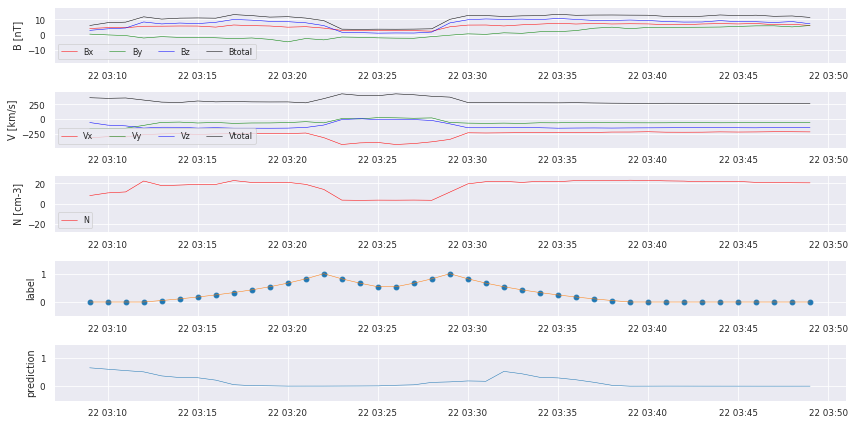

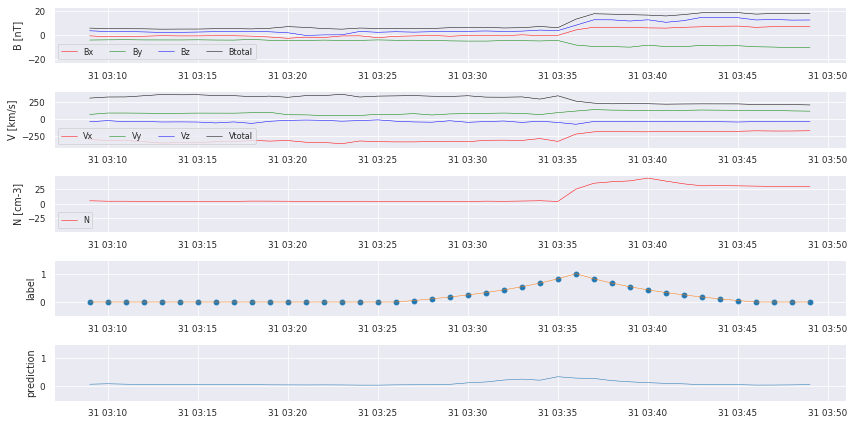

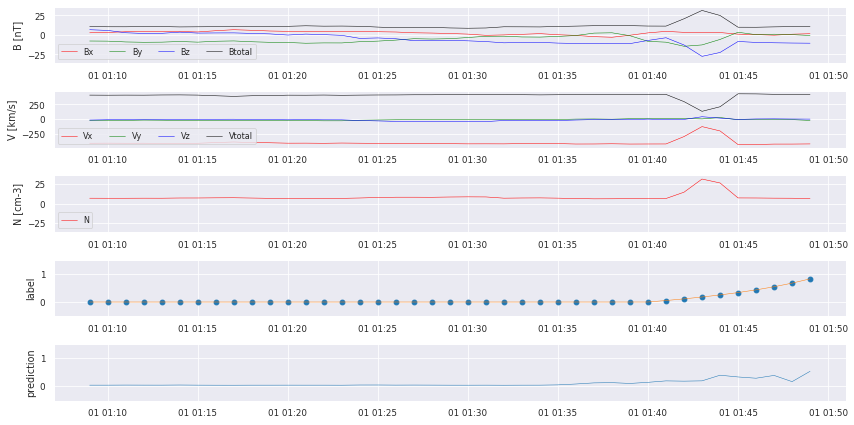

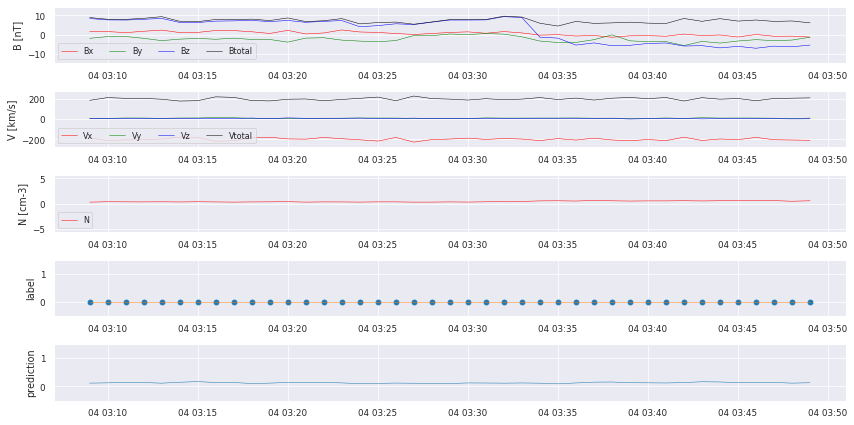

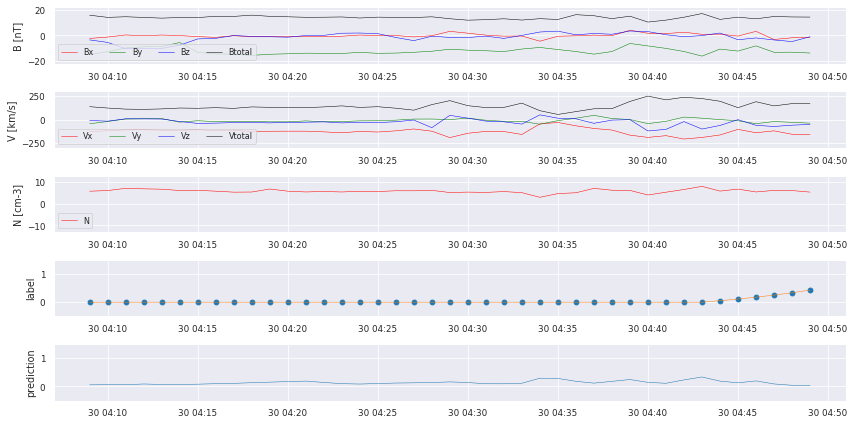

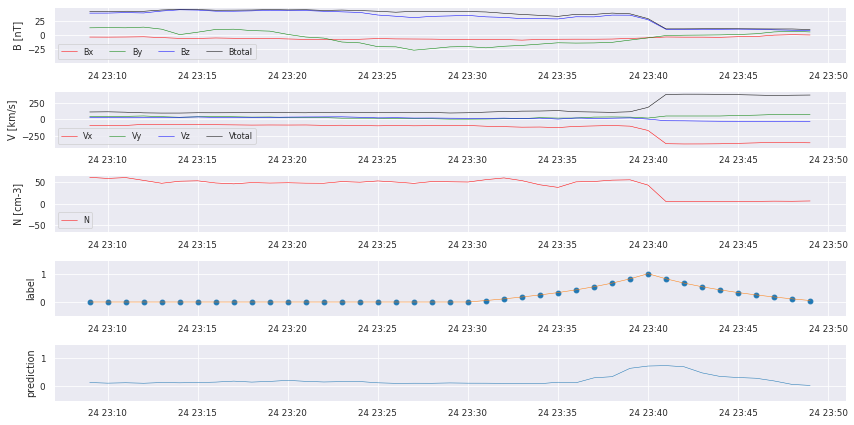

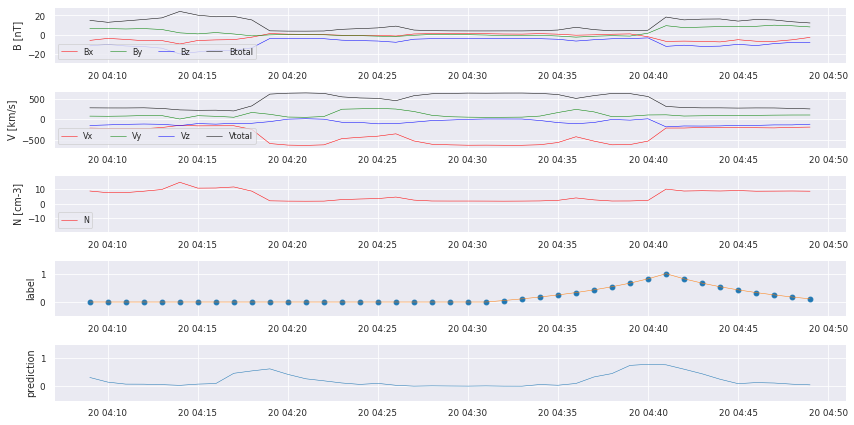

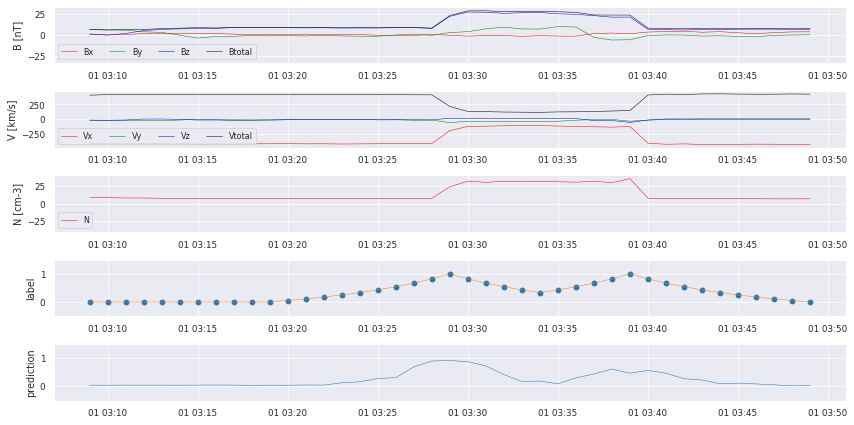

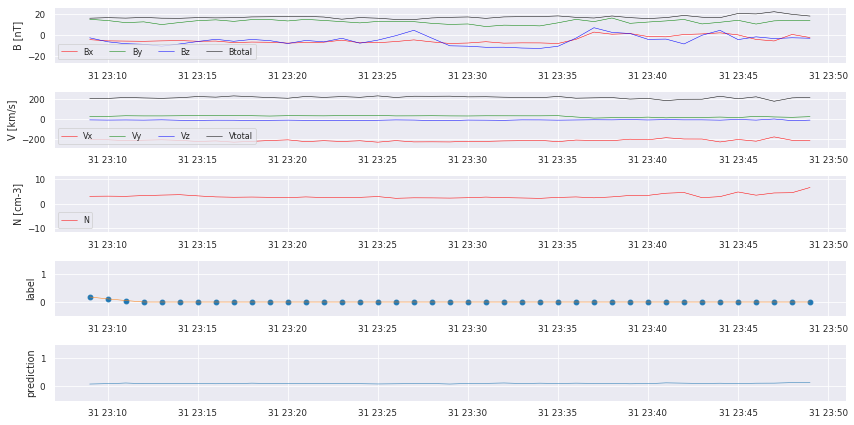

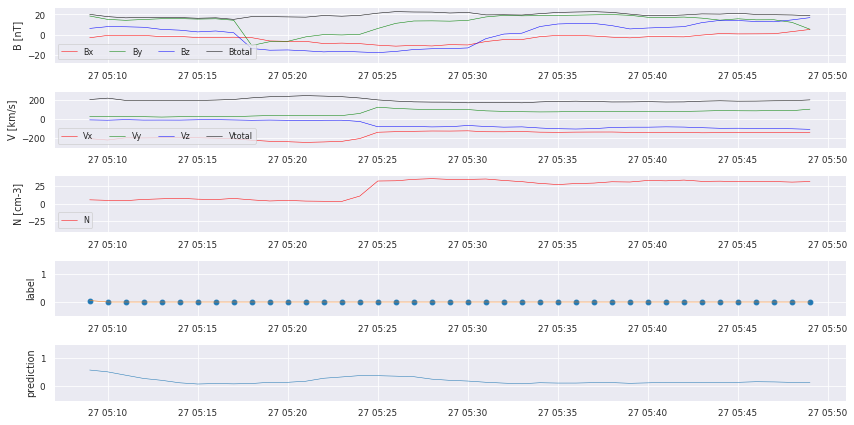

In [15]:
for i in testhours[0:10]:
    cr.plot_results(data,similarities,y_predSeries,i)

We can already see that there are some bumps where a crossing takes place, but we also missed some! We start with some postprocessing to turn the prediction into a comparable catalog.

In [16]:
import scipy.signal as ss
import postprocess

peaks = ss.find_peaks(y_predSeries['pred'].values,prominence=0.2)
predlist = []
for i in peaks[0]:
    predlist.append(cr.Crossing(y_predSeries.index[i]))

TP, FN, FP = postprocess.evaluate(predlist,testlist, thres=3)

Precision is: 0.5423728813559322
Recall is: 0.5161290322580645
True Positives 32
False Negatives 30
False Positives 27


We did manage to find some of the crossings, but there still is a lot of work to do:

- increase data
- use non-resampled dataset
- use additional features
- tune hyperparameters
- further experiment with model architecture
- crossvalidation